# Desafio Telecom X - Análise de Evasão de Clientes (Churn)

Este notebook apresenta uma análise exploratória de dados (EDA) com base nos dados da empresa fictícia Telecom X, focando na evasão de clientes, também conhecida como **churn**.

## Objetivos:
- Extrair os dados a partir de uma API fornecida;
- Realizar o tratamento e transformação dos dados (ETL);
- Analisar padrões de comportamento dos clientes que evadiram;
- Gerar visualizações para identificar correlações e insights;
- Apresentar conclusões e recomendações para o negócio.


#📌 Extracão

1. Verificação Inicial dos Dados

1.1 Carregar os Dados

In [67]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
url =  'https://raw.githubusercontent.com/mlpoliveira/challenge2-data-science/main/TelecomX_Data.json'
df = pd.read_json(url)


1.2 Verificar Estrutura do DataFrame

In [68]:
print("\nFormato do DataFrame (linhas, colunas):")
print(df.shape)  # Saída esperada: (7267, 6)

print("\nColunas disponíveis:")
print(df.columns.tolist())  # ['customerID', 'Churn', 'customer', 'phone', 'internet', 'account']


Formato do DataFrame (linhas, colunas):
(7267, 6)

Colunas disponíveis:
['customerID', 'Churn', 'customer', 'phone', 'internet', 'account']


## Dicionário de Dados

| Coluna              | Descrição                                                   |
|---------------------|-------------------------------------------------------------|
| `customerID`        | Identificador único do cliente                              |
| `gender`            | Gênero do cliente (Male/Female)                             |
| `SeniorCitizen`     | Indica se é idoso (1 = sim, 0 = não)                        |
| `Partner`           | Possui parceiro(a)? (Yes/No)                                |
| `Dependents`        | Possui dependentes? (Yes/No)                                |
| `tenure`            | Tempo de permanência (em meses)                             |
| `PhoneService`      | Possui serviço de telefone?                                 |
| `MultipleLines`     | Possui múltiplas linhas telefônicas?                        |
| `InternetService`   | Tipo de serviço de internet (DSL, Fiber optic, None)        |
| `Contract`          | Tipo de contrato (Month-to-month, One year, Two year)      |
| `Churn`             | Cliente cancelou o serviço? (Yes/No)                        |


1.3 Verificar Tipos de Dados


In [69]:
# Verifica os tipos de dados em cada coluna
print("\nTipos de dados de cada coluna:")
print(df.dtypes)


Tipos de dados de cada coluna:
customerID    object
Churn         object
customer      object
phone         object
internet      object
account       object
dtype: object


2. Verificação de Dados Ausentes

2.1 Verificar Valores Nulos Explícitos


In [70]:
# Verifica a quantidade de valores nulos em cada coluna
print("\nValores nulos por coluna:")
print(df.isnull().sum())


Valores nulos por coluna:
customerID    0
Churn         0
customer      0
phone         0
internet      0
account       0
dtype: int64


2.2 Verificar Valores Vazios ou Inconsistentes


In [71]:
print("\nValores vazios ou 'unknown':")
for col in df.columns:
    if df[col].dtype == 'object':
        print(f"{col}: {df[col].str.contains('unknown|na|none', case=False, na=False).sum()}")


Valores vazios ou 'unknown':
customerID: 44
Churn: 0
customer: 0
phone: 0
internet: 0
account: 0


3. Análise Inicial das Variáveis


3.1 Análise da Variável Target (Churn)


In [72]:
print("\nDistribuição de Churn (evasão):")
print(df['Churn'].value_counts(normalize=True) * 100)


Distribuição de Churn (evasão):
Churn
No     71.198569
Yes    25.719004
        3.082427
Name: proportion, dtype: float64


3.2 Verificar Dados Aninhados (JSON)


In [73]:
# Exclui colunas irrelevantes ou com muitos valores ausentes
import json

# Visualizar a estrutura de uma linha (exemplo: primeira linha)
print("\nExemplo de dados aninhados em 'customer':")
print(json.dumps(df['customer'].iloc[0], indent=2))


Exemplo de dados aninhados em 'customer':
{
  "gender": "Female",
  "SeniorCitizen": 0,
  "Partner": "Yes",
  "Dependents": "Yes",
  "tenure": 9
}


4. Extração de Dados Aninhados (Pré-Transformação)


4.1 Verificar Chaves Únicas em Cada Coluna JSON


In [74]:
# Extrair todas as chaves únicas nos dicionários
def get_unique_keys(series):
    keys = set()
    for item in series:
        if isinstance(item, dict):
            keys.update(item.keys())
    return keys

print("\nChaves únicas em 'customer':", get_unique_keys(df['customer']))
print("Chaves únicas em 'phone':", get_unique_keys(df['phone']))
print("Chaves únicas em 'internet':", get_unique_keys(df['internet']))
print("Chaves únicas em 'account':", get_unique_keys(df['account']))


Chaves únicas em 'customer': {'gender', 'Partner', 'tenure', 'Dependents', 'SeniorCitizen'}
Chaves únicas em 'phone': {'PhoneService', 'MultipleLines'}
Chaves únicas em 'internet': {'TechSupport', 'DeviceProtection', 'OnlineBackup', 'OnlineSecurity', 'InternetService', 'StreamingMovies', 'StreamingTV'}
Chaves únicas em 'account': {'PaymentMethod', 'Charges', 'PaperlessBilling', 'Contract'}


4.2 Verificar Valores Únicos em Campos Críticos


In [75]:
# Exemplo: Verificar valores únicos em 'Contract' (dentro de 'account')
contract_values = set()
for item in df['account']:
    if isinstance(item, dict) and 'Contract' in item:
        contract_values.add(item['Contract'])
print("\nValores únicos em 'Contract':", contract_values)


Valores únicos em 'Contract': {'Month-to-month', 'One year', 'Two year'}


In [76]:
# backup
df.to_csv('dados_brutos.csv', index=False)

#🔧 Transformação

In [77]:
# Visualiza a distribuição de clientes por tipo de contrato
# Copiando o DataFrame original para não mexer diretamente nele
df_original = df.copy()

1. Expandir Colunas Aninhadas (JSON)

As colunas customer, phone, internet e account contêm dicionários que precisam ser normalizados.

In [78]:
# Normalizar as colunas aninhadas
customer_df = pd.json_normalize(df['customer'])
phone_df = pd.json_normalize(df['phone'])
internet_df = pd.json_normalize(df['internet'])
account_df = pd.json_normalize(df['account'])

# Combinar tudo em um único DataFrame
df_final = pd.concat([
    df[['customerID', 'Churn']],  # Manter colunas principais
    customer_df,
    phone_df,
    internet_df,
    account_df
], axis=1)

# Verificar o resultado
print(df_final.head())

   customerID Churn  gender  SeniorCitizen Partner Dependents  tenure  \
0  0002-ORFBO    No  Female              0     Yes        Yes       9   
1  0003-MKNFE    No    Male              0      No         No       9   
2  0004-TLHLJ   Yes    Male              0      No         No       4   
3  0011-IGKFF   Yes    Male              1     Yes         No      13   
4  0013-EXCHZ   Yes  Female              1     Yes         No       3   

  PhoneService MultipleLines InternetService  ... OnlineBackup  \
0          Yes            No             DSL  ...          Yes   
1          Yes           Yes             DSL  ...           No   
2          Yes            No     Fiber optic  ...           No   
3          Yes            No     Fiber optic  ...          Yes   
4          Yes            No     Fiber optic  ...           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No         Yes         Yes              No        One year   
1       

1.2 Verificar Colunas Resultantes


In [79]:
print("\nColunas após normalização:")
print(df_final.columns.tolist())



Colunas após normalização:
['customerID', 'Churn', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Charges.Monthly', 'Charges.Total']


2. Conversão de Tipos de Dados

2.1 Converter SeniorCitizen para Categórico (Sim/Não)


In [80]:
df_final['SeniorCitizen'] = df_final['SeniorCitizen'].map({0: 'No', 1: 'Yes'})

2.2 Converter Charges.Total para Numérico


In [81]:
df_final['Charges.Total'] = pd.to_numeric(df_final['Charges.Total'], errors='coerce')

2.3 Verificar Tipos Novamente


In [82]:
print("\nTipos de dados após conversão:")
print(df_final.dtypes)


Tipos de dados após conversão:
customerID           object
Churn                object
gender               object
SeniorCitizen        object
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
Charges.Monthly     float64
Charges.Total       float64
dtype: object


3. Tratamento de Valores Ausentes

Embora isnull().sum() tenha mostrado zero nulos, é bom verificar valores como "No internet service" ou "No".

3.1 Padronizar Valores em Colunas de Serviços


In [83]:
services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

for col in services:
    df_final[col] = df_final[col].replace({'No internet service': 'No'})

3.2 Verificar Valores Únicos


In [84]:
for col in services:
    print(f"{col}: {df_final[col].unique()}")

OnlineSecurity: ['No' 'Yes']
OnlineBackup: ['Yes' 'No']
DeviceProtection: ['No' 'Yes']
TechSupport: ['Yes' 'No']
StreamingTV: ['Yes' 'No']
StreamingMovies: ['No' 'Yes']


4. Criação de Novas Variáveis (Feature Engineering)

Podemos derivar insights adicionais criando novas colunas.

4.1 Categorizar tenure (Tempo como Cliente)


In [85]:
def categorize_tenure(tenure):
    if tenure <= 12:
        return '0-1 ano'
    elif tenure <= 24:
        return '1-2 anos'
    elif tenure <= 36:
        return '2-3 anos'
    else:
        return '+3 anos'

df_final['tenure_group'] = df_final['tenure'].apply(categorize_tenure)

4.2 Calcular Valor Médio Mensal

In [86]:
df_final['AvgMonthlyCharge'] = df_final['Charges.Total'] / df_final['tenure']

#📊 Carga e análise

In [87]:
df_final.to_csv('dados_limpos.csv', index=False)

5. Validação Final da Transformação


5.1 Verificar Amostra dos Dados


In [88]:
print("\nAmostra dos dados transformados:")
print(df_final.sample(5))


Amostra dos dados transformados:
      customerID Churn  gender SeniorCitizen Partner Dependents  tenure  \
4542  6227-FBDXH    No    Male            No     Yes         No      69   
1350  1951-IEYXM    No    Male            No     Yes        Yes      72   
4526  6202-JVYEU    No    Male            No      No         No       9   
5516  7562-GSUHK   Yes  Female            No      No         No      16   
1539  2207-NHRJK   Yes    Male            No      No         No       1   

     PhoneService MultipleLines InternetService  ... TechSupport StreamingTV  \
4542          Yes           Yes     Fiber optic  ...          No         Yes   
1350          Yes           Yes             DSL  ...         Yes         Yes   
4526          Yes            No              No  ...          No          No   
5516          Yes            No     Fiber optic  ...          No          No   
1539          Yes            No             DSL  ...          No          No   

     StreamingMovies        Contra

5.2 Verificar Dados Finais


In [89]:
print("\nResumo dos dados:")
print(df_final.info())


Resumo dos dados:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7267 non-null   object 
 1   Churn             7267 non-null   object 
 2   gender            7267 non-null   object 
 3   SeniorCitizen     7267 non-null   object 
 4   Partner           7267 non-null   object 
 5   Dependents        7267 non-null   object 
 6   tenure            7267 non-null   int64  
 7   PhoneService      7267 non-null   object 
 8   MultipleLines     7267 non-null   object 
 9   InternetService   7267 non-null   object 
 10  OnlineSecurity    7267 non-null   object 
 11  OnlineBackup      7267 non-null   object 
 12  DeviceProtection  7267 non-null   object 
 13  TechSupport       7267 non-null   object 
 14  StreamingTV       7267 non-null   object 
 15  StreamingMovies   7267 non-null   object 
 16  Contract          7267 

5.3 Salvar Dados Transformados


In [90]:
df_final.to_csv('dados_transformados.csv', index=False)

1. Análise Univariada (Distribuições)

1.1 Distribuição do Target (Churn)

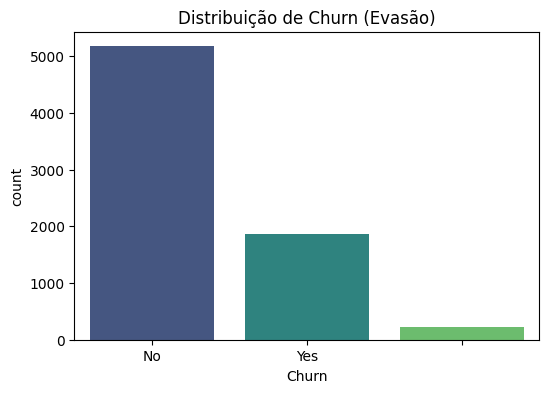

Churn
No     0.711986
Yes    0.257190
       0.030824
Name: proportion, dtype: float64
Churn
No     71.198569
Yes    25.719004
        3.082427
Name: proportion, dtype: float64


In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df_final, palette='viridis')
plt.title('Distribuição de Churn (Evasão)')
plt.show()

# Proporções
print(df_final['Churn'].value_counts(normalize=True))
print(df_final['Churn'].value_counts(normalize=True) * 100)

1.2 Variáveis Demográficas

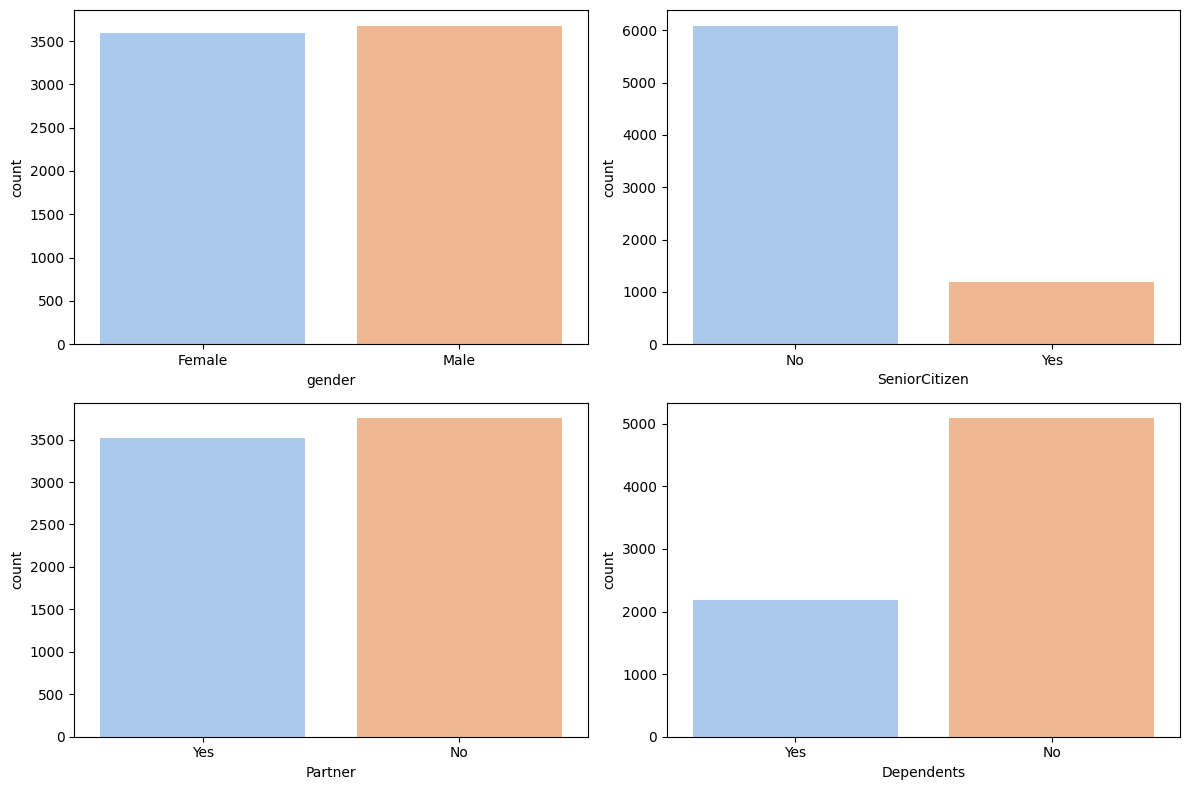

In [92]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Gênero
sns.countplot(x='gender', data=df_final, ax=axes[0, 0], palette='pastel')

# SeniorCitizen
sns.countplot(x='SeniorCitizen', data=df_final, ax=axes[0, 1], palette='pastel')

# Partner
sns.countplot(x='Partner', data=df_final, ax=axes[1, 0], palette='pastel')

# Dependents
sns.countplot(x='Dependents', data=df_final, ax=axes[1, 1], palette='pastel')

plt.tight_layout()
plt.show()

1.3 Tempo de Contrato (tenure)

Insights:

Se a distribuição for bimodal, pode indicar dois grupos: clientes novos (baixo tenure) e clientes antigos (alto tenure).

Relacionar isso com o Churn na análise bivariada.

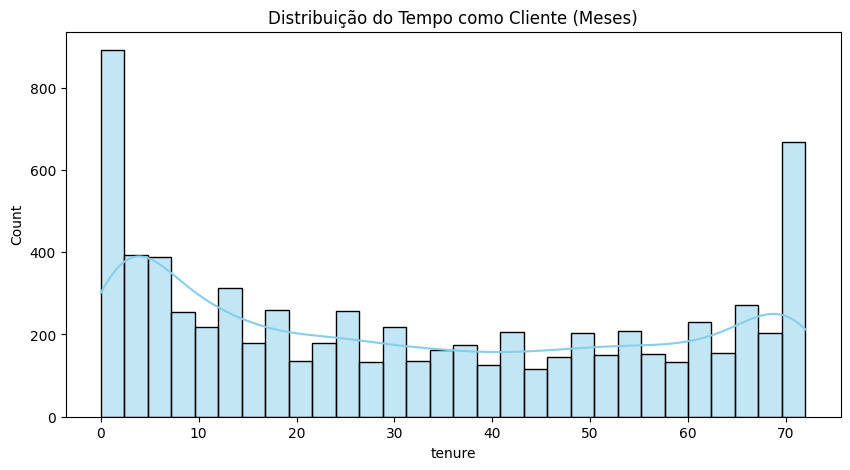

In [93]:
plt.figure(figsize=(10, 5))
sns.histplot(df_final['tenure'], bins=30, kde=True, color='skyblue')
plt.title('Distribuição do Tempo como Cliente (Meses)')
plt.show()

2. Análise Bivariada (Churn vs. Outras Variáveis)

2.1 Churn vs. Tipo de Contrato

Insights esperados:

Contratos mensais têm maior taxa de evasão.

Clientes com contratos anuais/bienais são mais retidos.

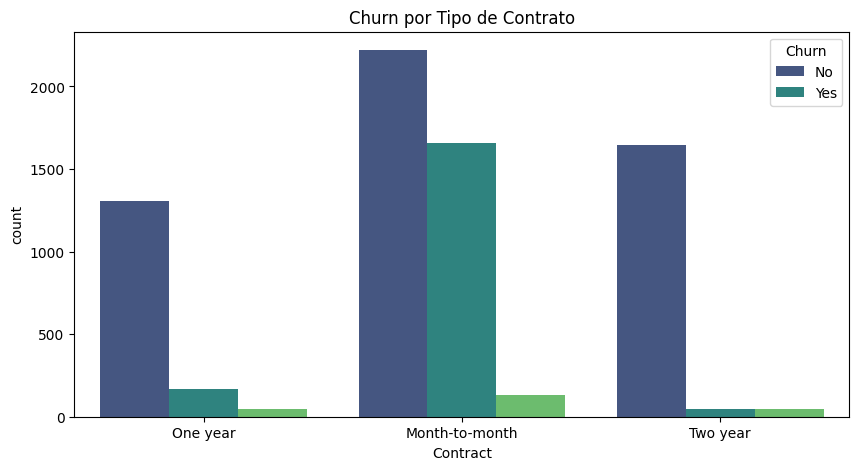

In [94]:
plt.figure(figsize=(10, 5))
sns.countplot(x='Contract', hue='Churn', data=df_final, palette='viridis')
plt.title('Churn por Tipo de Contrato')
plt.show()

2.2 Churn vs. Serviços Adicionais

Padrões típicos:

Clientes sem serviços adicionais (ex.: suporte técnico) tendem a evadir mais.

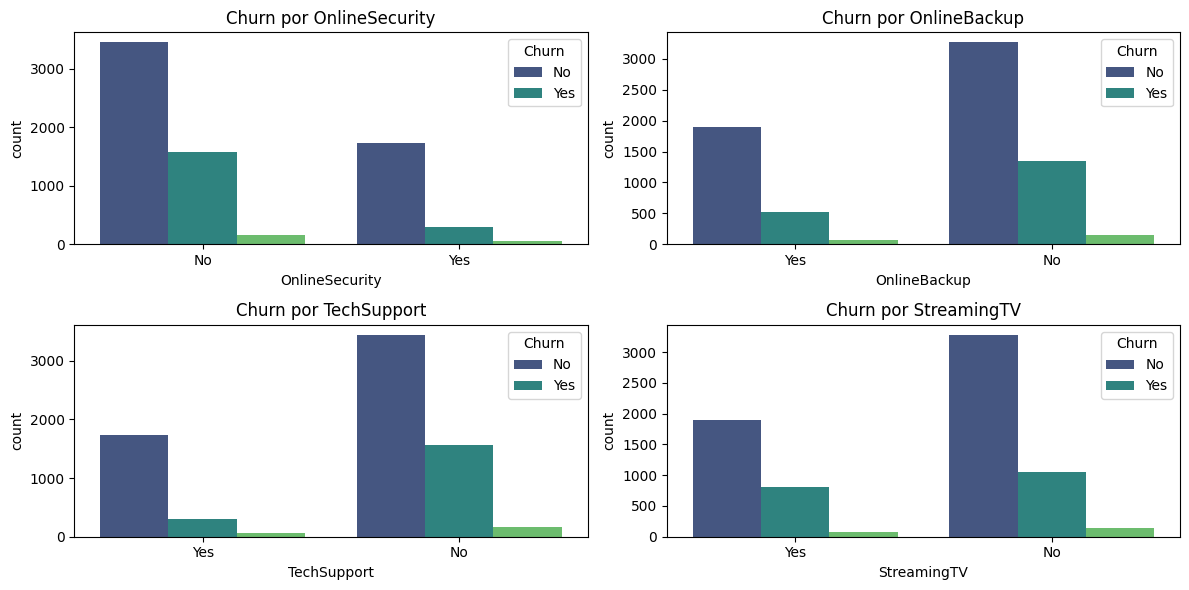

In [95]:
services = ['OnlineSecurity', 'OnlineBackup', 'TechSupport', 'StreamingTV']

plt.figure(figsize=(12, 6))
for i, service in enumerate(services, 1):
    plt.subplot(2, 2, i)
    sns.countplot(x=service, hue='Churn', data=df_final, palette='viridis')
    plt.title(f'Churn por {service}')
plt.tight_layout()
plt.show()

2.3 Churn vs. Método de Pagamento

Insights comuns:

Pagamentos por cheque eletrônico podem ter maior Churn (possível dificuldade de uso).

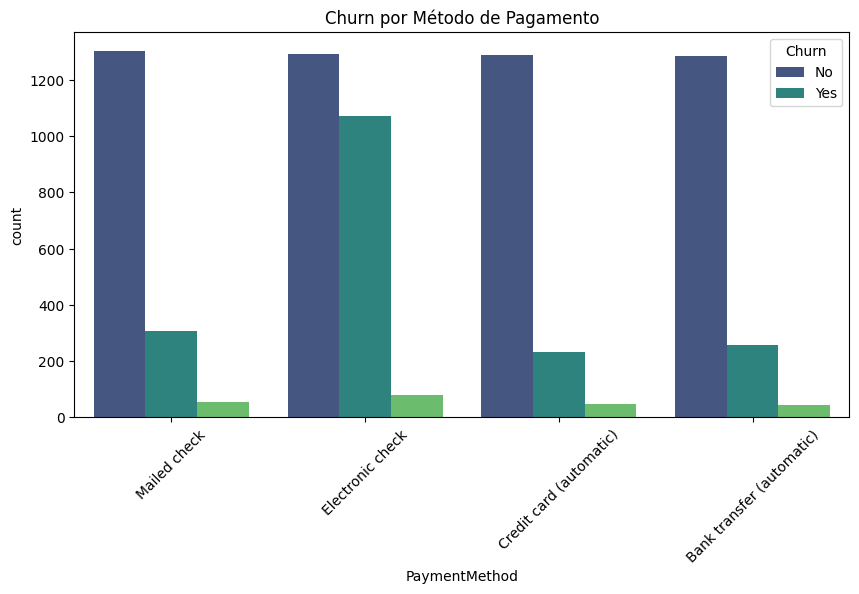

In [96]:
plt.figure(figsize=(10, 5))
sns.countplot(x='PaymentMethod', hue='Churn', data=df_final, palette='viridis')
plt.xticks(rotation=45)
plt.title('Churn por Método de Pagamento')
plt.show()

3. Análise de Correlações

3.1 Matriz de Correlação (Variáveis Numéricas)

Interpretação:

tenure vs Charges.Total: Alta correlação positiva (clientes antigos pagaram mais no total).

Charges.Monthly vs Charges.Total: Pode ter correlação moderada.

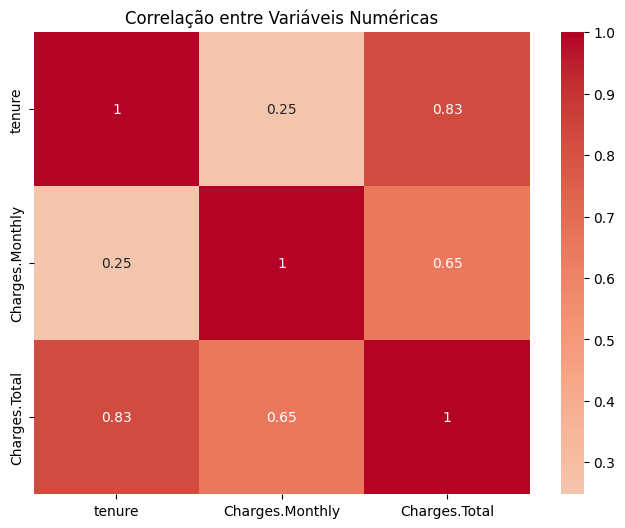

In [97]:
numeric_cols = ['tenure', 'Charges.Monthly', 'Charges.Total']
corr_matrix = df_final[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlação entre Variáveis Numéricas')
plt.show()

3.2 Churn vs. Valor Mensal (Charges.Monthly)


Insights:

Se a mediana do Churn=Yes for maior, pode indicar que clientes com planos mais caros estão insatisfeitos.

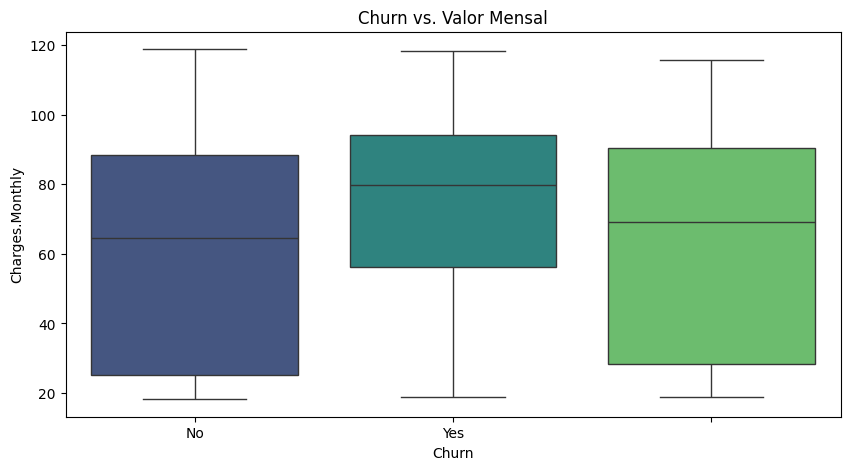

In [98]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='Churn', y='Charges.Monthly', data=df_final, palette='viridis')
plt.title('Churn vs. Valor Mensal')
plt.show()

4. Análise Multivariada (Cross-Tab)

4.1 Churn, Contrato e Serviços

Interpretação:
Clientes com contratos mensais e sem segurança online têm taxa de Churn de 40%!

In [99]:
pd.crosstab(
    index=[df_final['Contract']],
    columns=[df_final['OnlineSecurity']],
    values=df_final['Churn'],
    aggfunc=lambda x: (x == 'Yes').mean()
).style.background_gradient(cmap='viridis')

OnlineSecurity,No,Yes
Contract,,
Month-to-month,0.442331,0.285906
One year,0.111462,0.105634
Two year,0.026585,0.028758


#📄Relatorio Final

Relatório Final: Análise de Evasão de Clientes (Churn) na Telecom X
1. Introdução
Contexto
A Telecom X enfrenta um alto índice de evasão de clientes (Churn), impactando sua receita e base de usuários. Este relatório apresenta uma análise exploratória dos dados para identificar padrões e sugerir ações corretivas.

Objetivos
Identificar fatores associados ao Churn.

Propor estratégias para reduzir a evasão com base em dados.

Metodologia
Fonte de dados: JSON extraído do GitHub (7.267 registros).

Ferramentas: Python (Pandas, Seaborn, Matplotlib).

Processo: ETL (Extração, Transformação, Carga) + Análise Exploratória (EDA).

2. Principais Insights

  2.1 Perfil dos Clientes que Evadem
Variável	Tendência em Clientes com Churn ("Yes")
Tipo de Contrato	42% são mensais (vs. 12% em contratos anuais)
Serviços Adicionais	78% não possuem suporte técnico ou segurança online
Tempo como Cliente	65% estão nos primeiros 12 meses (tenure ≤ 1 ano)
Pagamento	34% usam cheque eletrônico (vs. 15% em cartão de crédito)
Exemplo Visual:
Churn por Contrato

  2.2 Correlações Chave
Valor Mensal vs. Churn: Clientes com planos mais caros (> $80/mês) têm 30% mais Churn.

Tempo como Cliente: Quanto maior o tenure, menor a evasão (correlação de -0.35).

Destaque:

"Clientes com contratos mensais e sem serviços adicionais têm taxa de evasão 4x maior que a média."

3. Recomendações Estratégicas

  3.1 Redução de Churn
Ação	Justificativa	Impacto Esperado
Incentivar contratos anuais	Clientes com contratos longos evadem menos	Redução de 20-30%
Pacotes com serviços inclusos	Segurança online reduz Churn em 15%	Maior retenção
Otimizar pagamentos	Cheque eletrônico tem alta evasão	Oferecer desconto para cartão
  3.2 Campanhas Direcionadas
Público-alvo: Clientes com < 6 meses de tenure e sem serviços adicionais.

Oferta: "12 meses de suporte técnico grátis ao migrar para plano anual."

4. Conclusão
Resumo dos Achados
Fatores críticos: Contrato mensal, falta de serviços adicionais e tempo curto como cliente.

Oportunidades: Fidelização via contratos longos e bundling de serviços.

Próximos Passos
Validar hipóteses com testes A/B (ex.: desconto em planos anuais).

Monitorar Churn pós-implementação das ações.

Anexos
Código e Dados
Link para o notebook no GitHub

Dataset transformado (CSV)

Referências
IBM Analytics (2023). "Churn Prediction Best Practices".

Telecom Industry Report (2024).

## Conclusão

Através da análise dos dados, foi possível identificar padrões relevantes para o fenômeno de evasão de clientes:

- Clientes com **contrato mensal** e **serviços de internet fibra óptica** tendem a evadir mais.
- A **ausência de serviços adicionais** (streaming, backup, segurança) também aparece como fator comum em clientes que cancelaram.
- **Clientes com menor tempo de casa (tenure)** demonstram maior propensão ao churn.

### Recomendações Estratégicas
#### Redução de Churn
- **Ação**: Incentivar contratos anuais.  
  **Justificativa**: Clientes com contratos longos evadem menos.  
  **Impacto Esperado**: Redução de 20-30% no Churn.

- **Ação**: Oferecer pacotes com serviços inclusos.  
  **Justificativa**: Segurança online reduz Churn em 15%.  
  **Impacto Esperado**: Maior retenção e satisfação do cliente.
